

# Leaf Segmentation with <img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">

Trains a detectron2 model on Superfund leaf dataset.



# Setup

### Install requirements

In [2]:
%%capture

# requirements
!pip install pyyaml==5.1
!pip install opencv-python
!pip install matplotlib
!pip install openpyxl

# cocosplit requirements
!pip install sklearn funcy argparse scikit-multilearn

### Import Detectron2 and other Python Libraries

In [3]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

torch:  1.12 ; cuda:  cu116


# Prepare the Data

### Split dataset into train and test sets for k-fold cross validation

To make better use our small dataset (~176 images), we use k-fold cross validation.

First, we add some variables to specify where output from this training run should be stored, including the split k-fold test/train annotations and final model weights.  Set `today` to today's date and set `suffix` to specify how you'd like your output folder named (defaults to `kfold_train`).

In [4]:
# set this to today's date
today = "2023-05-09"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder = today + "_" + suffix

Next set the number of folds for k-fold cross validation (defaults to k=5, which is pretty standard).

In [5]:
# number of folds for k-fold cross validation
k = 5

Next we run the `cocosplit_kfold` script to split the images into k folds and get the training and test sets for each iteration of k-fold cross validation. You can add the `-p` flag if you'd like to see the train/test indicies for each k-fold iteration to verify this is working as expected.

In [6]:
# shuffle and randomly split into k folds
run = f"python ./cocosplit_kfold.py\
         -k {k}\
         data/leaves-coco-verified.json\
         /home/jovyan/work/{output_folder}" 

!{run}

Filtered out 18 images missing manual area calculations.
Final dataset size: 176 images

Fold 0
Training set size: 140 
Test set size: 36

Fold 1
Training set size: 141 
Test set size: 35

Fold 2
Training set size: 141 
Test set size: 35

Fold 3
Training set size: 141 
Test set size: 35

Fold 4
Training set size: 141 
Test set size: 35


Now, in the output folder, you should see JSON files containing the annotations for the training & test set for each iteration of k-fold cross validation.  For example `train_0.json` and `test_0.json` respectively contain the training and test annotations for the first training iteration.

### Register the dataset with Detectron2

Register the leaf dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [7]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances

for fold in range(0, k):

    register_coco_instances(f"train_{fold}", {}, f"/home/jovyan/work/{output_folder}/train_{fold}.json", "/home/jovyan/work/data/")
    register_coco_instances(f"val_{fold}", {}, f"/home/jovyan/work/{output_folder}/test_{fold}.json", "/home/jovyan/work/data/")



To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [05/22 18:24:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/22 18:24:26 d2.data.datasets.coco]: Loaded 140 images in COCO format from /home/jovyan/work/2023-05-09_kfold_train/train_0.json
Metadata(name='train_0', json_file='/home/jovyan/work/2023-05-09_kfold_train/train_0.json', image_root='/home/jovyan/work/data/', evaluator_type='coco', thing_classes=['leaf', 'qr', 'red-square'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})


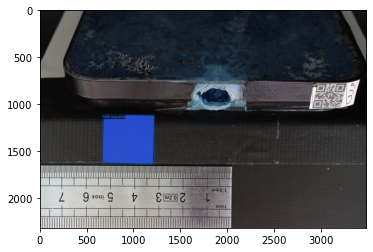

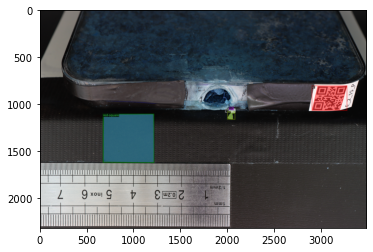

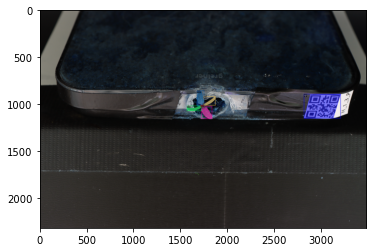

In [8]:
leaf_metadata = MetadataCatalog.get("train_0")
dataset_dicts = DatasetCatalog.get("train_0")

print(leaf_metadata)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


# Time to Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the leaf dataset.


In [9]:
import os

import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import CityscapesSemSegEvaluator, DatasetEvaluators, SemSegEvaluator
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler


def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN,
            cfg.INPUT.MAX_SIZE_TRAIN,
            cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        ),
        T.RandomFlip(),
        T.RandomBrightness(0.8, 1.2)
    ]

    return augs


class AugmentedTrainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    @classmethod
    def build_train_loader(cls, cfg):
        
        print('Building custom train loader...')
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)



In [ ]:
from detectron2.engine import DefaultTrainer

for fold in range(3, 5):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    
    cfg.DATASETS.TRAIN = (f"train_{fold}",)
    cfg.DATASETS.TEST = ()
    
    cfg.DATALOADER.NUM_WORKERS = 2
    
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # leaf dataset has 3 classes (leaf, qr, red-square)
    
    cfg.OUTPUT_DIR = f'./{output_folder}/fold_{fold}'
    # cfg.INPUT.CROP.ENABLED = True
    
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = AugmentedTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()


[05/23 06:46:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[05/23 06:46:42 d2.engine.train_loop]: Starting training from iteration 0
[05/23 06:47:09 d2.utils.events]:  eta: 1:41:00  iter: 19  total_loss: 3.678  loss_cls: 1.473  loss_box_reg: 0.2038  loss_mask: 0.6937  loss_rpn_cls: 1.106  loss_rpn_loc: 0.1157  time: 1.2461  data_time: 1.1431  lr: 4.9953e-06  max_mem: 3209M
[05/23 06:47:33 d2.utils.events]:  eta: 1:40:24  iter: 39  total_loss: 3.287  loss_cls: 1.327  loss_box_reg: 0.2531  loss_mask: 0.6893  loss_rpn_cls: 0.84  loss_rpn_loc: 0.1398  time: 1.2374  data_time: 1.0472  lr: 9.9902e-06  max_mem: 3209M
[05/23 06:47:58 d2.utils.events]:  eta: 1:39:56  iter: 59  total_loss: 2.518  loss_cls: 1.078  loss_box_reg: 0.3076  loss_mask: 0.6808  loss_rpn_cls: 0.3664  loss_rpn_loc: 0.1115  time: 1.2380  data_time: 1.0594  lr: 1.4985e-05  max_mem: 3209M
[05/23 06:48:23 d2.utils.events]:  eta: 1:39:32  iter: 79  total_loss: 2.39  loss_cls: 0.8454  loss_box_reg: 0.3882  loss_mask: 0.6695  loss_rpn_cls: 0.3184  loss_rpn_loc: 0.1388  time: 1.2371  dat

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("val")
leaf_metadata = MetadataCatalog.get("val")

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leaf_metadata, 
                   # scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()